# Import files

In [21]:
from Strats.PairTradingStrat import *
from Strats.PortfolioMetrics import *
from Strats.WRC import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [22]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [ ]:
coint_pairs = get_coint_pairs(BTC_pairs, interval = '5m', start_date="2023-01-01", end_date="2023-12-31")
len(coint_pairs)

In [45]:
# test_pairs = coint_pairs[10:12]
test_pairs = ['WBTCBTC', 'OGBTC']
print(test_pairs)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_pairs:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2023-01-01",
        end_date="2024-12-31"
    )

pair_portfolio

['WBTCBTC', 'OGBTC']
'WBTCBTC' added successfully.
'OGBTC' added successfully.


,timestamp,OGBTC,WBTCBTC
0,2023-01-01 00:00:00,0.000143,0.9986
1,2023-01-01 00:05:00,0.000143,0.9986
2,2023-01-01 00:10:00,0.000143,0.9986
3,2023-01-01 00:15:00,0.000143,0.9986
4,2023-01-01 00:20:00,0.000143,0.9987
...,...,...,...
210220,2024-12-30 23:40:00,0.000052,0.9991
210221,2024-12-30 23:45:00,0.000052,0.9991
210222,2024-12-30 23:50:00,0.000052,0.9991
210223,2024-12-30 23:55:00,0.000052,0.9991


In [133]:
class pair_trading:
    def __init__(self, df, weights):
        self.df = df
        self.tickers = df.columns.tolist()[1:]
        self.weights = weights

    def generate_signals(self, lookback, execute_threshold, close_threshold):
        # Calculate the rolling mean with a window size of lookback
        for t in self.tickers:
            self.df[t+'_rolling_mean'] = self.df[t].rolling(window=lookback).mean()
            self.df[t+'_rolling_std'] = self.df[t].rolling(window=lookback).std()
            self.df[t+'_z_scores'] = (self.df[t] - self.df[t+'_rolling_mean']) / self.df[t+'_rolling_std']

            self.df[t+'_signal'] = np.where((self.df[t+'_z_scores'] > execute_threshold) | (self.df[t+'_z_scores'] < -execute_threshold), 1, 0)
            # self.df.loc[self.df[t+'_z_scores'] > execute_threshold, t+'_signal'] = -1
            # self.df.loc[self.df[t+'_z_scores'] < -execute_threshold, t+'_signal'] = 1
            self.df[t+"_signal"] = self.df[t+"_signal"].fillna(0)

            self.df[t+'_exit_signal'] = np.where((self.df[t+'_z_scores'] > -close_threshold) & (self.df[t+'_z_scores'] < close_threshold), 1, 0)
            self.df[t+"_exit_signal"] = self.df[t+"_exit_signal"].fillna(0)

        return self.df


    def plot_signals(self, ticker):
        fig, axs = plt.subplots(2,1, figsize=(15,9), sharex=True)
        axs[0].plot(self.df[ticker+"_z_scores"], label="Z-score")
        axs[0].axhline(0,color='red')
        axs[0].set_ylabel("Z Scores")
        axs[0].set_xlabel("Date")
        axs[0].legend()
        axs[0].grid(True)
        axs[0].plot(self.df.loc[self.df[ticker+"_signal"] == -1].index, self.df[ticker+"_z_scores"][self.df[ticker+"_signal"] == -1], color='r', marker="v", linestyle='')
        axs[0].plot(self.df.loc[self.df[ticker+"_signal"] == +1].index, self.df[ticker+"_z_scores"][self.df[ticker+"_signal"] == +1], color='g', marker="^", linestyle='')

        axs[1].plot(self.df[ticker], label="Asset y")
        axs[1].legend()
        axs[1].grid(True)
        plt.show()

    def computePnL(self, ticker, test_start_date): #have not account for capital
        trades = self.df[self.df['timestamp'] >= test_start_date].copy().reset_index(drop=True)
        # PnL variables - one set per security
        position = 0
        pnlUnrealized = 0
        pnlRealized = 0

        avg_short_price = 0
        short_pos = 0
        avg_long_price = 0
        long_pos = 0
        closed_pos = 0

        positions = []
        pnlUnrealized_list = []
        pnlRealized_list = []
        daily_pnl = []
        daily_pnl_pct = []

        # for each trade
        for i in range(0, len(trades)):
            qty = trades[ticker+'_signal'][i]
            price = trades[ticker][i]
            exit_signal = trades[ticker+'_exit_signal'][i]

            if exit_signal == 1:
                if position != 0:
                    qty = -position #close position

            if qty < 0:
                avg_short_price = (avg_short_price * short_pos + price * qty) / (short_pos + qty)
                short_pos += qty
            elif qty > 0:
                avg_long_price = (avg_long_price * long_pos + price * qty) / (long_pos + qty)
                long_pos += qty

            if i > 0:
                if (qty * position) < 0:
                    closed_pos = min(abs(qty), abs(position))
                else:
                    closed_pos = 0
                short_pos += closed_pos
                long_pos -= closed_pos

                if (position+qty) < 0:
                    pnlUnrealized = (avg_short_price - price) * -(position+qty)
                else:
                    pnlUnrealized = (avg_long_price - price) * (position+qty)
                # print(closed_pos)

            position += qty
            pnlRealized += (avg_short_price - avg_long_price) * closed_pos
            daily_pnl += [(avg_short_price - avg_long_price) * closed_pos + pnlUnrealized]

            positions += [position]
            pnlUnrealized_list += [pnlUnrealized]
            pnlRealized_list += [pnlRealized]
            try:
                daily_pnl_pct += [((pnlRealized+pnlUnrealized) - (pnlUnrealized_list[-2] + pnlRealized_list[-2]))/(pnlUnrealized_list[-2] + pnlRealized_list[-2])]
            except:
                daily_pnl_pct += [np.nan]

            if short_pos == 0:
                avg_short_price = 0
            if long_pos == 0:
                avg_long_price = 0

        pnl_df = trades[["timestamp", ticker, ticker+"_signal"]].copy()
        pnl_df.columns = ["Date", "Price", "Signal"]
        pnl_df["Positions"] = positions
        pnl_df["Realized_PnL"] = pnlRealized_list
        pnl_df["Unrealized_PnL"] = pnlUnrealized_list
        pnl_df["Daily_PnL"] = daily_pnl
        pnl_df["Daily_PnL_Pct"] = daily_pnl_pct
        pnl_df["PnL_Total"] = pnl_df["Realized_PnL"] + pnl_df["Unrealized_PnL"]

        return pnl_df

    def computePortfolioPnL(self, test_start_date):
        portfolioPnL = pd.DataFrame()
        for ind, t in enumerate(self.tickers):
            pnl_df = self.computePnL(t, test_start_date)
            portfolioPnL[t+"_daily_pnl"] = pnl_df["Daily_PnL"]
            portfolioPnL[t+"_daily_pnl_pct"] = pnl_df["Daily_PnL_Pct"]
            if ind > 0:
                portfolioPnL["total_daily_pnl"] = portfolioPnL["total_daily_pnl"] + portfolioPnL[t+"_daily_pnl"] * self.weights[ind]
                portfolioPnL["total_daily_pnl_pct"] = portfolioPnL["total_daily_pnl_pct"] + portfolioPnL[t+"_daily_pnl_pct"] * self.weights[ind]
                portfolioPnL["total_pnl"] = portfolioPnL["total_pnl"] + pnl_df["PnL_Total"] * self.weights[ind]
            else:
                portfolioPnL["total_daily_pnl"] = portfolioPnL[t+"_daily_pnl"] * self.weights[ind]
                portfolioPnL["total_daily_pnl_pct"] = portfolioPnL[t+"_daily_pnl_pct"] * self.weights[ind]
                portfolioPnL["total_pnl"] = pnl_df["PnL_Total"] * self.weights[ind]

        portfolioPnL["timestamp"] = pnl_df["Date"]
        portfolioPnL = portfolioPnL[["timestamp", "total_daily_pnl", "total_daily_pnl_pct", "total_pnl"]]

        return portfolioPnL

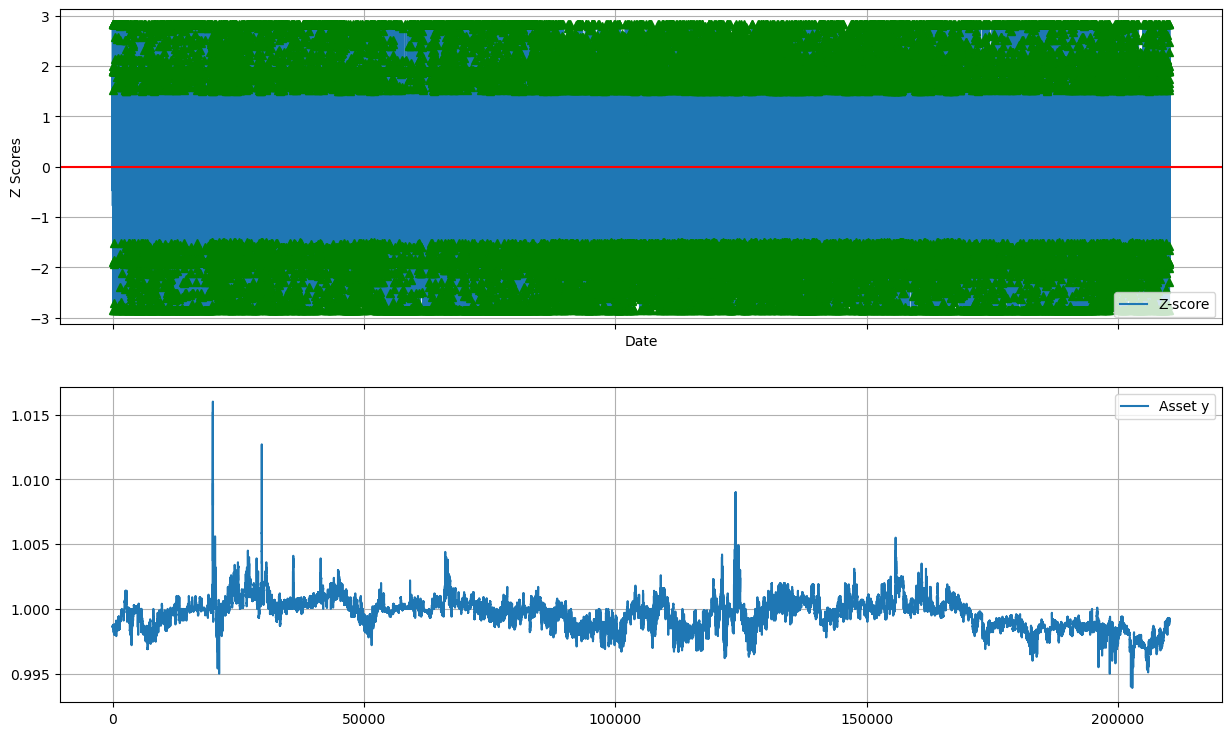

In [134]:
weights = np.array([1/len(test_pairs) for i in range(len(test_pairs))])
model = pair_trading(pair_portfolio.copy(), weights)
spread = model.generate_signals(lookback=10, execute_threshold=1.5, close_threshold=0.5)
model.plot_signals(test_pairs[0])

In [135]:
spread

,timestamp,OGBTC,WBTCBTC,OGBTC_rolling_mean,OGBTC_rolling_std,OGBTC_z_scores,OGBTC_signal,OGBTC_exit_signal,WBTCBTC_rolling_mean,WBTCBTC_rolling_std,WBTCBTC_z_scores,WBTCBTC_signal,WBTCBTC_exit_signal
0,2023-01-01 00:00:00,0.000143,0.9986,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0
1,2023-01-01 00:05:00,0.000143,0.9986,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0
2,2023-01-01 00:10:00,0.000143,0.9986,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0
3,2023-01-01 00:15:00,0.000143,0.9986,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0
4,2023-01-01 00:20:00,0.000143,0.9987,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210220,2024-12-30 23:40:00,0.000052,0.9991,0.000052,3.204164e-07,1.123538,0,0,0.99910,0.000115,0.000000,0,1
210221,2024-12-30 23:45:00,0.000052,0.9991,0.000052,3.348300e-07,0.925843,0,0,0.99911,0.000110,-0.090867,0,1
210222,2024-12-30 23:50:00,0.000052,0.9991,0.000052,3.169297e-07,0.757266,0,0,0.99911,0.000110,-0.090867,0,1
210223,2024-12-30 23:55:00,0.000052,0.9991,0.000052,2.790858e-07,0.609132,0,0,0.99909,0.000088,0.114208,0,1


In [136]:
pnl_df = model.computePortfolioPnL(test_start_date="2024-01-01")
pnl_df

,timestamp,total_daily_pnl,total_daily_pnl_pct,total_pnl
0,2024-01-01 00:00:00,0.000000e+00,NaN,0.000000
1,2024-01-01 00:05:00,0.000000e+00,NaN,0.000000
2,2024-01-01 00:10:00,0.000000e+00,NaN,0.000000
3,2024-01-01 00:15:00,0.000000e+00,NaN,0.000000
4,2024-01-01 00:20:00,0.000000e+00,NaN,0.000000
...,...,...,...,...
105116,2024-12-30 23:40:00,0.000000e+00,-0.00000,-0.058384
105117,2024-12-30 23:45:00,0.000000e+00,-0.00000,-0.058384
105118,2024-12-30 23:50:00,0.000000e+00,-0.00000,-0.058384
105119,2024-12-30 23:55:00,0.000000e+00,-0.00000,-0.058384


In [137]:
price_fetcher = BinancePriceFetcher(test_pairs)
# Fetch pair historical price
pair_portfolio_momentum = pair_portfolio[pair_portfolio["timestamp"] >= "2024-01-01"].reset_index(drop=True)

weights = np.array([0.5, 0.5])  # Equal-weighted

# Initialize strategy
strategy = SimpleStrategy(
    tickers=test_pairs,
    weights=weights,
    data=pair_portfolio_momentum
)

print(pair_portfolio.shape)
# Get momentum strategy returns
momentum_returns = strategy.momentum_strategy(lookback=30, hold_period=10)

(210225, 3)


# Comparison

In [138]:
returns = pd.DataFrame()
returns["Momentum"] = momentum_returns
returns["Pair_Trade"] = pnl_df[("total_daily_pnl_pct")]

port_metrics = PortfolioMetrics(returns.dropna())
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Momentum            -0.000694           5.702247e-02      0.015944   
Pair_Trade           0.516633           1.764907e+11     -0.026540   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio    Skewness  \
Momentum                   135438 -6.367260e-01 -1.089876e-03    6.697282   
Pair_Trade                 135438 -2.707896e+10  1.907875e-11 -168.295112   

                Kurtosis  VaR (5%)     CVaR (5%)  Tail Ratio  Omega Ratio  
Momentum      380.527932  -0.00431 -9.899121e-03    0.943105     1.008301  
Pair_Trade  55890.974163  -0.00431 -6.586871e+08    0.943105     0.585352  


In [139]:
wrc = WhiteRealityCheck(strategies=returns["Pair_Trade"], benchmark=returns["Momentum"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.517
consistent    0.721
upper         0.721
dtype: float64
Superior strategy indices:
[]


[]